In [89]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
from matplotlib import ticker
from scipy import stats

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

data_path = os.path.join(os.path.pardir, 'tradeoffs')


def filter_data(data, bench, operation, filter_first_n=0):
    filtered_data = []
    ignore_count = 0
    for entry in data:
        if "msg" in entry and entry["msg"] == "Start benchmark":
            ignore_count += filter_first_n
        elif "bench" in entry and entry["bench"] == bench and "operation" in entry and entry["operation"] == operation:
            if ignore_count == 0:
                filtered_data.append(entry)
            else:
                ignore_count -= 1
    return filtered_data


def get_msg(entry):
    if "message" in entry:
        return entry["message"]

    if "msg" in entry:
        return entry["msg"]

    return ""



def read_data(path):
    global warmup
    data = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("{"):
                entry = json.loads(line)
                msg = get_msg(entry)
                if msg == "Benchmark result" or msg == "Start benchmark":
                    data.append(entry)
                elif msg == "Config":
                    warmup = entry["warmup"]
    return data

data = read_data(os.path.join(data_path, 'gyorgy_step_results.txt'))
filtered_data = filter_data(data, "BenchSteppedCreate", "session_creation")

print(filtered_data)

[{'level': 'info', 'ts': 1666516835.6932151, 'logger': 'praas-control-plane', 'caller': 'bench-master/master.go:165', 'msg': 'Benchmark result', 'bench': 'BenchSteppedCreate', 'version': 'kubernetes', 'step_size': 1, 'start_size': 0, 'operation': 'session_creation', 'value': 1717}, {'level': 'info', 'ts': 1666516877.1245842, 'logger': 'praas-control-plane', 'caller': 'bench-master/master.go:165', 'msg': 'Benchmark result', 'bench': 'BenchSteppedCreate', 'version': 'kubernetes', 'step_size': 1, 'start_size': 0, 'operation': 'session_creation', 'value': 1296}, {'level': 'info', 'ts': 1666516920.035902, 'logger': 'praas-control-plane', 'caller': 'bench-master/master.go:165', 'msg': 'Benchmark result', 'bench': 'BenchSteppedCreate', 'version': 'kubernetes', 'step_size': 1, 'start_size': 0, 'operation': 'session_creation', 'value': 1201}, {'level': 'info', 'ts': 1666516963.039385, 'logger': 'praas-control-plane', 'caller': 'bench-master/master.go:165', 'msg': 'Benchmark result', 'bench': 'B

/tmp/ipykernel_963223/2988625427.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [28]:
def p50_estimator(x):
    return np.percentile(x, 50)
def p95_estimator(x):
    return np.percentile(x, 95)
def p99_estimator(x):
    return np.percentile(x, 99)

In [39]:
bg_num_field = "start_size"
version_field = "version"
value_field = "value"
import statistics

def get_unique_fields(data, fields):
    result = dict()
    for field in fields:
        result[field] = set()

    for entry in data:
        for field in fields:
            if field in entry:
                result[field].add(entry[field])
    return result

dfs = []
def get_versions_and_vals(data, x_field, quantile):
    fields = get_unique_fields(data, [x_field, version_field])
    sorted_versions = sorted(fields[version_field])
    sorted_x = sorted(fields[x_field])

    versions_and_vals = dict()
    for version in sorted_versions:
        vv = dict()
        versions_and_vals[version] = vv
        vv["vals"] = all_vals = dict()
        vv["y_vals"] = y_vals = []
        vv["errors"] = errors = [[], []]
        vv["x_vals"] = plotted_x_vals = []

        for x_val in sorted_x:
            vals = []
            minimum = None
            maximum = None
            idx = -1
            for entry in data:
                if entry[version_field] == version and entry[x_field] == x_val:
                    idx += 1
                    #print(idx, warmup)
                    if idx >= warmup:
                        val = entry[value_field]
                        vals.append(val)
                        #print(version, x_val, val, idx)
                        #print('ok')
                        dfs.append([version, x_val, val, idx])
                        if minimum is None or val < minimum:
                            minimum = val
                        if maximum is None or val > maximum:
                            maximum = val
            if len(vals) > 1:
                all_vals[x_val] = vals
                plotted_x_vals.append(x_val)
                y_val = statistics.median(vals)
                y_vals.append(y_val)
                errors[0].append(y_val - np.quantile(vals, 1 - quantile))
                errors[1].append(np.quantile(vals, quantile) - y_val)

    return versions_and_vals
versions_and_vals = get_versions_and_vals(filtered_data, bg_num_field, 0.99)
print(dfs)
df = pd.DataFrame(data=dfs, columns=['type', 'pods', 'time', 'idx'])
#print(versions_and_vals)

[['kubernetes', 0, 1296, 1], ['kubernetes', 0, 1201, 2], ['kubernetes', 0, 1162, 3], ['kubernetes', 0, 1192, 4], ['kubernetes', 0, 1311, 5], ['kubernetes', 10, 1160, 1], ['kubernetes', 10, 1181, 2], ['kubernetes', 10, 1209, 3], ['kubernetes', 10, 1150, 4], ['kubernetes', 10, 1251, 5], ['kubernetes', 20, 1317, 1], ['kubernetes', 20, 1171, 2], ['kubernetes', 20, 1150, 3], ['kubernetes', 20, 1185, 4], ['kubernetes', 20, 1202, 5], ['kubernetes', 30, 1183, 1], ['kubernetes', 30, 1136, 2], ['kubernetes', 30, 1343, 3], ['kubernetes', 30, 1155, 4], ['kubernetes', 30, 1240, 5], ['kubernetes', 40, 1201, 1], ['kubernetes', 40, 1184, 2], ['kubernetes', 40, 1219, 3], ['kubernetes', 40, 1283, 4], ['kubernetes', 40, 1449, 5], ['kubernetes', 50, 1168, 1], ['kubernetes', 50, 1169, 2], ['kubernetes', 50, 1245, 3], ['kubernetes', 50, 1361, 4], ['kubernetes', 50, 1177, 5], ['kubernetes', 60, 1497, 1], ['kubernetes', 60, 1177, 2], ['kubernetes', 60, 1588, 3], ['kubernetes', 60, 1155, 4], ['kubernetes', 60,

In [40]:
print(df.groupby(['type', 'pods']).count())

                 time  idx
type       pods           
kubernetes 0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
           90       5    5
           100      5    5
           110      5    5
           120      5    5
praas-k8s  0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
           90       5    5
           100      5    5
           110      5    5
           120      5    5
praas-kn   0        5    5
           10       5    5
           20       5    5
           30       5    5
           40       5    5
           50       5    5
           60       5    5
           70       5    5
           80       5    5
 

/tmp/ipykernel_963223/3393515004.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_963223/3393515004.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(


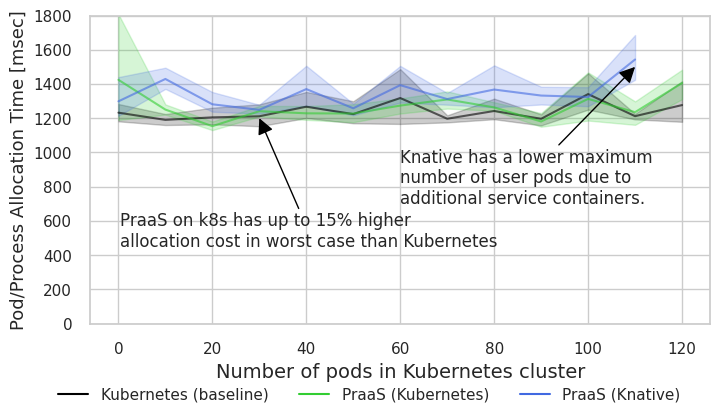

In [87]:

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")
ax = plt.gca()


color = ['black','limegreen','royalblue','navy']


sns.lineplot(
    data=df,
    x="pods", y="time", hue="type", hue_order=["kubernetes", "praas-k8s", "praas-kn"],
    errorbar="ci", alpha=.6,#, height=6,
    #estimator=p50_estimator,
    palette=color,
    ax=ax
)

ax.set_xlabel('Number of pods in Kubernetes cluster',fontsize=14)
ax.set_ylabel('Pod/Process Allocation Time [msec]',fontsize=13)
ax.set_ylim([0, 1800])


ax.legend(loc='center', bbox_to_anchor=(0.45, -0.23),
    handles=ax.get_legend_handles_labels()[0],
    labels=['Kubernetes (baseline)', 'PraaS (Kubernetes)', 'PraaS (Knative)'],
    ncols=4        
)

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",color='black',shrinkA=0,shrinkB=0)

plt.annotate("PraaS on k8s has up to 15% higher\nallocation cost in worst case than Kubernetes",
             ha='left',xy=(30,1200), xytext=(0.3,450), arrowprops=prop)

plt.annotate("Knative has a lower maximum\nnumber of user pods due to\nadditional service containers.",
             ha='left',xy=(110,1500), xytext=(60,700), arrowprops=prop)

#plt.annotate("Difference between PraaS (k8s) and k8sAllocation of processesLower maximum number", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)

#plt.annotate("Difference between PraaS (k8s) and k8sAllocation of processesLower maximum number", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)


#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)

ax.figure.savefig("tradeoff_allocation.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)


In [94]:

print('k8s', 'praask8s', 'delta', 'ratio', 'coefficient of variance (praask8s)', 'coefficient of variance (k8s)')
for pods in range(0,130,10):
    k8s = df.loc[(df['type'] == 'kubernetes') & (df['pods'] == pods)]['time'].mean()
    k8s_dev = df.loc[(df['type'] == 'kubernetes') & (df['pods'] == pods)]['time'].std()
    praask8s = df.loc[(df['type'] == 'praas-k8s') & (df['pods'] == pods)]['time'].mean()
    praask8s_dev = df.loc[(df['type'] == 'praas-k8s') & (df['pods'] == pods)]['time'].std()
    knative = df.loc[(df['type'] == 'knative') & (df['pods'] == pods)]['time'].mean()
    print(k8s,praask8s,praask8s-k8s,praask8s/k8s, praask8s_dev/praask8s*100, k8s_dev/k8s*100)

print(df.groupby(['type', 'pods']).mean())

k8s praask8s delta ratio coefficient of variance (praask8s) coefficient of variance (k8s)
1232.4 1424.4 192.0 1.1557935735150926 30.338657806335807 5.412453212630696
1190.2 1250.4 60.200000000000045 1.0505797344984036 3.123407653314376 3.4290865508973924
1205.0 1153.6 -51.40000000000009 0.9573443983402489 2.7580324463747514 5.431406887907712
1211.4 1241.0 29.59999999999991 1.0244345385504374 3.2387818711460743 6.882982775705278
1267.2 1228.6 -38.600000000000136 0.9695391414141413 4.457583044214005 8.54760736640735
1224.0 1227.4 3.400000000000091 1.0027777777777778 5.167792766038784 6.783998097359077
1318.0 1273.8 -44.200000000000045 0.966464339908953 4.424730836070311 15.752278327600584
1197.0 1309.6 112.59999999999991 1.0940685045948204 4.997182732193674 2.261818942469655
1242.2 1263.2 21.0 1.0169054902592176 2.6678394844542366 6.242020414955897
1196.6 1180.8 -15.799999999999955 0.986795921778372 4.718440716058717 3.52958854495298
1341.0 1313.0 -28.0 0.9791200596569725 13.793006938482

In [5]:

data_docker = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_docker.csv'))
#data.set_index('id', drop=True, inplace=True)
data_docker['time'] /= 1000.0 * 1000.0
data_docker['type'] = 'praas_local'
data_docker.drop(['repetition'], axis=1, inplace=True)

data_cpu = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_1cpu.csv'))
#data.set_index('id', drop=True, inplace=True)
data_cpu['time'] /= 1000.0 * 1000.0
data_cpu['type'] = 'praas_local'
data_cpu.drop(['repetition'], axis=1, inplace=True)

for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    
    local = data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median()
    cpu = data_cpu.loc[(data_cpu['type'] == 'praas_local') & (data_cpu['size'] == size)]['time'].median()
    docker = data_docker.loc[(data_docker['type'] == 'praas_local') & (data_docker['size'] == size)]['time'].median()
    print(docker, local)
    print('1CPU', 1 - cpu/local)
    print('Docker', local/docker)
    

0.0637885 0.07331950000000001
1CPU 0.06796282025927636
Docker 1.1494156470210148
0.0659865 0.0740715
1CPU 0.07297003570874083
Docker 1.1225250619444886
0.294107 0.34975900000000004
1CPU 0.13810509522271064
Docker 1.1892236498961264
3.2509865 4.19101
1CPU 0.11862104838690435
Docker 1.289150231783491
17.2484045 21.327219499999998
1CPU 0.07364070595325367
Docker 1.2364749156943762


In [102]:

data_path = os.path.join(os.path.pardir, 'swapper')
# read praas data
#for size in sizes:
data = pd.read_csv(os.path.join(data_path, 'swapper_s3_fargate.csv'), sep=',| ')
#print(data)
#data.set_index('id', drop=True, inplace=True)
data['time'] /= 1000.0 * 1000.0
data['type'] = 's3'
data.drop(['repetition'], axis=1, inplace=True)

data_path = os.path.join(os.path.pardir, 'swapper')
# read praas data
#for size in sizes:
data_ec2 = pd.read_csv(os.path.join(data_path, 'swapper_s3_ec2.csv'), sep=',| ')
#print(data)
#data.set_index('id', drop=True, inplace=True)
data_ec2['time'] /= 1000.0 * 1000.0
data_ec2['type'] = 's3'
data_ec2.drop(['repetition'], axis=1, inplace=True)


/tmp/ipykernel_963223/3016954115.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(data_path, 'swapper_s3_fargate.csv'), sep=',| ')
/tmp/ipykernel_963223/3016954115.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_ec2 = pd.read_csv(os.path.join(data_path, 'swapper_s3_ec2.csv'), sep=',| ')


In [115]:
print(data.loc[data['threads'] == 1].groupby(['size', 'threads']).median())
serial = data_ec2.loc[data_ec2['threads'] == 1].groupby(['size', 'threads']).median()
print(serial)
#print(data_ec2.loc[data['threads'] == 1])
#print(serial)
for i in [2,4,8,16]:

    par = data_ec2.loc[data_ec2['threads'] == i].groupby(['size', 'threads']).median()
    print(par)
    print(serial['time']/par['time'].unstack())

                          time
size      threads             
1048576   1          98.391388
5242880   1         172.957722
10485760  1         231.908379
52428800  1         907.679747
104857600 1        1719.261522
209715200 1        3480.382454
                          time
size      threads             
1048576   1         120.464402
5242880   1         172.816928
10485760  1         220.233451
52428800  1         791.843570
104857600 1        1525.742670
209715200 1        2930.542878
                          time
size      threads             
1048576   2         101.954372
5242880   2         160.740203
10485760  2         210.993630
52428800  2         675.714073
104857600 2        1290.927250
209715200 2        2504.709104
threads     1   2
size             
1048576   NaN NaN
5242880   NaN NaN
10485760  NaN NaN
52428800  NaN NaN
104857600 NaN NaN
209715200 NaN NaN
                          time
size      threads             
1048576   4         128.630792
5242880   4        

In [120]:

data_path = os.path.join(os.path.pardir, 'tradeoffs')
# read praas data
#for size in sizes:
data = pd.read_csv(os.path.join(data_path, 'deallocation_gyorgy.txt'), sep=' ')
print(data)
print(data.groupby(['type', 'pods'])['time'].mean())
print(data.groupby(['type', 'pods'])['time'].median())
#data.set_index('id', drop=True, inplace=True)
#data['time'] /= 1000.0 * 1000.0
#data['type'] = 's3'
#data.drop(['repetition'], axis=1, inplace=True)


           type  pods   time  repetition
0    kubernetes     0   1841           2
1    kubernetes     0    146           3
2    kubernetes     0   2040           4
3    kubernetes     0     57           5
4    kubernetes    10    179           2
..          ...   ...    ...         ...
147    praas-kn   100  61126           5
148    praas-kn   110  61028           2
149    praas-kn   110  60967           3
150    praas-kn   110  61975           4
151    praas-kn   110  61920           5

[152 rows x 4 columns]
type        pods
kubernetes  0        1021.00
            10        162.75
            20       1455.00
            30       1854.00
            40       1873.50
            50       1889.25
            60       1873.75
            70       1882.50
            80        750.25
            90       1430.00
            100      1872.50
            110      1870.75
            120      1929.50
praas-k8s   0        1502.75
            10       1741.00
            20       1853.00
   

In [127]:
praas =  [19.514  , 37.3035  ,54.745 ,  73.1925 ,92.186  ,111.0485 ,131.5405 ,150.858, 171.9675, 192.324]
#knative_redis = [99.05336213938426, 199.60586244560545, 300.3434340173844, 401.4079687320045, 504.23066347499844, 604.345674819604, 707.1062631753739, 808.8358128094696, 912.0894554774277, 1011.6328345205402]
knative_s3 = [117.166 , 134.9585 ,153.7695 ,173.8185 ,192.759 , 212.2635, 232.3915, 253.261, 273.9675, 292.292]

In [128]:
for i in range(len(praas)):
    print(knative_s3[i]/praas[i])

6.004202111304704
3.6178508719021
2.8088318567905746
2.3748129931345425
2.0909791074566635
1.911448601286825
1.7666916272934952
1.678803908311127
1.5931353308037854
1.519789521848547
